<a href="https://colab.research.google.com/github/alejandrodgb/fastai-course22/blob/main/00-OWN-is-it-a-bird-creating-a-model-from-your-own-data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install libraries
import sys

# Preparing notebook for google colab
if 'google.colab' in sys.modules:
    !pip install -Uqq fastai
    !pip install -Uqq duckduckgo_search

In [2]:
# Import libraries
from fastcore.all import *
from duckduckgo_search import ddg_images

We will be classifying wether the image has a cow or a horse. Steps to clasify:
1. Download cow and horse images
2. Fine-tune a pretrained neural network to recognise the two groups
3. Test it on a new image

# Step 1: Download images

In [3]:
# Function to download images
def search_images(term, max_images=200):
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [4]:
# Search images function returns the url for the search term
urls = search_images('thoroughbred',1)
urls

(#1) ['https://cdn.bloodhorse.com/proclaim/images/2015/08/96806d78-19e7-444e-9053-ca22bb781525_lf-xl.jpg']

In [5]:
# Import fastai
from fastdownload import download_url
from fastai.vision.all import *

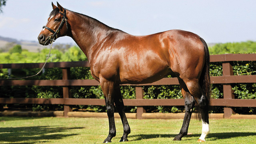

In [6]:
# Download test image
dest = 'data/thoroughbred.jpg'
download_url(search_images('thoroughbred',1)[0],dest)
Image.open(dest).to_thumb(256,256)

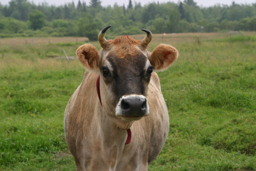

In [7]:
# Download test image
dest = 'data/cow.jpg'
download_url(search_images('cow',1)[0],dest)
Image.open(dest).to_thumb(256,256)

In [8]:
# Search for 200 images of each class
searches = 'thoroughbred','cow'
path = Path('data/what_horse')

from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True,parents=True)
    download_images(dest,urls=search_images(f'{o} photo'))
    sleep(10)
    download_images(dest,urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest,urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

In [9]:
# Verify downloads
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

28

# Step 2: Model training

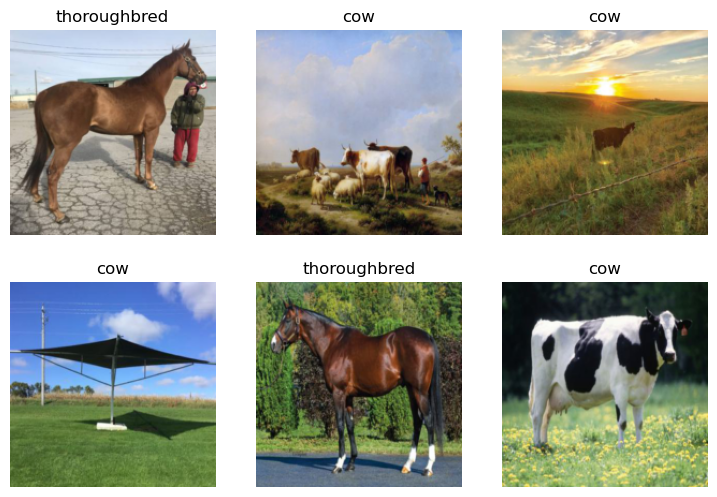

In [10]:
# Create a dataloader
dls = DataBlock(blocks=(ImageBlock, CategoryBlock),
                get_items=get_image_files,
                splitter=RandomSplitter(valid_pct=0.2,seed=42),
                get_y=parent_label,
                item_tfms=[Resize(192,method='squish')]).dataloaders(path)

dls.show_batch(max_n=6)

In [11]:
# Finetune resnet18

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

C:\Users\alexb\Anaconda3\envs\fastai\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\alexb\Anaconda3\envs\fastai\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.707450,0.208530,0.081731,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.262883,0.240888,0.067308,00:04
1,0.148507,0.234312,0.067308,00:04
2,0.094513,0.176009,0.057692,00:04
3,0.064177,0.162468,0.043269,00:04


# Step 3: Predictions

In [12]:
# Prediction
learn.predict(PILImage.create('data/thoroughbred2.jpg'))

('thoroughbred', TensorBase(1), TensorBase([4.9633e-05, 9.9995e-01]))